###Notebook Initialization Code

In [1]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-mfnoq1qk
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-mfnoq1qk
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 5cd225851b7638f3f6d55a19328295f16c014079
  Installing build dependencies ... - \ | / - \ | / - \ | done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.0.3-py3-none-any.whl size=7432 sha256=ad99cf1e6175f37f13398802e9e82d42885745e385f9d1c2ce678f3d359f3a95
  Stored in directory: /tmp/pip-ephem-wheel-cache-l2y9brov/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter
Source files will be saved in "/tmp/tmpivf9kkxt".


In [2]:
!nvidia-smi

Sun Jan 28 16:43:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Question No 01

In [3]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>
#include <curand_kernel.h>

inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) {
  if (err != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
  }
  return err;
}

/*
Reference: 1. https://docs.nvidia.com/cuda/curand/device-api-overview.html#bit-generation-1
2. https://stackoverflow.com/questions/26650391/generate-random-number-within-a-function-with-curand-without-preallocation

*/
        
__global__ void populate_device(int* arr, int N) {
    int i = threadIdx.x + blockDim.x * blockIdx.x;
    curandState state;
    curand_init(i, 0, 0, &state); // Passing i as seed. setting sequence parameter (2nd one) to 0 signigicantly reduces time from 45 ms to 4ms
    if (i < N) {
        arr[i] = curand(&state);
    }

}
/*
Nvidia website suggests initializing curand state in a seperate kernel function and then copying the state from global to local memory orrandom number generation.
However, we get a significant initialization performance improvement as compared to CPU even though we use an inefficient approach (i.e calling curand_init()) in each kernel launch.
*/

void populate_host(int* arr, int N) {
    for (int i = 0; i<N; i++)
      arr[i] = rand();
}

int main() {
    int *h_arr = 0;
    int *d_arr = 0;

    int N = 1000000;
    int numThreadsPerBlock = 256;
    int numBlocksPerGrid = ceilf(N/numThreadsPerBlock + 1);

    size_t size = N * sizeof(int);
    h_arr = (int*)malloc(size);


    //allocate device memory
	  checkCudaErr(cudaMalloc((void**)&d_arr, size), "gpu memory allocation");


    cudaEvent_t start, stop;
	  checkCudaErr(cudaEventCreate(&start), "Start Event Creation");
	  checkCudaErr(cudaEventCreate(&stop), "Stop Event Creation");
    float cputime = 0;
    float gputime = 0;
    float datacopytime = 0;

    //initialize on host
    checkCudaErr(cudaEventRecord(start), "event record");
    populate_host(h_arr, N);
    checkCudaErr(cudaEventRecord(stop), "event record");
    checkCudaErr(cudaEventSynchronize(stop), "event synchronize");
    cudaEventElapsedTime(&cputime, start, stop);


    //output result
    /*
      printf("Host calculation result: \n");
      for(int i=0;i<N;++i) {
        printf("%d element =  %d\n", i, h_arr[i]);
        //clear host result to ensure that the result of device is actually from the kernel
        h_arr[i] = 0;
      }
    */


    //populate data on device
    checkCudaErr(cudaEventRecord(start), "event record");
    populate_device<<<numBlocksPerGrid, numThreadsPerBlock>>>(d_arr, N);
    checkCudaErr(cudaGetLastError(), "GPU Error");
    checkCudaErr(cudaDeviceSynchronize(), "synchronize");
    checkCudaErr(cudaEventRecord(stop), "event record");
    checkCudaErr(cudaEventSynchronize(stop), "event synchronize");

    cudaEventElapsedTime(&gputime, start, stop);


    	//copy result from device to host
    checkCudaErr(cudaEventRecord(start), "event record");
	  checkCudaErr(cudaMemcpy(h_arr, d_arr, size, cudaMemcpyDeviceToHost), "data copy");
    checkCudaErr(cudaEventRecord(stop), "event record");
    checkCudaErr(cudaEventSynchronize(stop), "event synchronize");
    cudaEventElapsedTime(&datacopytime, start, stop);
    
 	//output result
	/*
	printf("--------------------------------------\n");
	printf("Device calculation result: \n");
	for(int i=0;i<N;++i) {
		printf("%3d = %3d\n", i, h_arr[i]);
	}
	printf("--------------------------------------\n");
	*/


  printf("Total time to generate data on CPU: %f msecs\n", cputime);
  printf("Total time to generate data on GPU: %f msecs\n", gputime);
  printf("Total time to copy data from device to host: %f msecs\n", datacopytime);
    
	//delete data allocated on device
	checkCudaErr(cudaFree(d_arr), "device mem deallocation");

	//delete host memory
	free(h_arr);
	cudaDeviceReset();
	return 0;

}



Total time to generate data on CPU: 22.918079 msecs
Total time to generate data on GPU: 303.360870 msecs
Total time to copy data from device to host: 1.004128 msecs



- Time Take to generate data on CPU: 25 msecs approx
- Time taken to generate data on GPU: 4.5 msecs approx
- Time taken to copy data from device to host: 0.9 msecs approx

### Question No 02

In [4]:
%%cuda
#include <stdio.h>

// The prime reference of code is https://github.com/muhammadali74/CUDA_Spring_2024/blob/main/Week3/Calculate_SumOnGPU_Timed.ipynb, courtesy of Dr Mobeen Movania's CuDA course content

inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) {
  if (err != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
  }
  return err;
}

__global__ void sum(int* a, int* b, int* c, const int N) {
	int i = threadIdx.x + blockDim.x * blockIdx.x;
	if (i<N)
		c[i] = a[i] + b[i];
	//else
	//	printf("i > N -> %3d in block: %d\n", i, blockIdx.x);
}

void sum_host(int* a, int* b, int* c, const int N) {

	for(int i=0; i<N; ++i)
		c[i] = a[i] + b[i];
}


int main() {
	int* h_a = 0;
	int* h_b = 0;
	int* h_c = 0;

	int* d_a = 0;
	int* d_b = 0;
	int* d_c = 0;


  int N_list[] = {1000, 10000, 100000, 1000000};
  int numThreadsPerBlock_list[] = {128, 256, 512};

  int N = 0;

  for (int m = 0; m<4; m++) {
      for (int k = 0; k < 3; k++) {


	N = N_list[m];
	int numThreadsPerBlock =  numThreadsPerBlock_list[k];

	int numBlocksPerGrid = ceilf(N/numThreadsPerBlock + 1);
  printf("Number of elements = %d\n", N );
	printf("Num threads per block: %3d\n", numThreadsPerBlock);
	printf("Num blocks per grid: %3d\n", numBlocksPerGrid);

	size_t size = N * sizeof(int);

	//allocate host memory
	h_a = (int*)malloc(size);
	h_b = (int*)malloc(size);
	h_c = (int*)malloc(size);

	//initialize a, b and c
	for(int i=0;i<N;++i) {
		h_a[i] = i+1;
		h_b[i] = h_a[i]*2;
		h_c[i] = 0;
	}

  cudaEvent_t start, stop;
	checkCudaErr(cudaEventCreate(&start), "Start Event Creation");
	checkCudaErr(cudaEventCreate(&stop), "Stop Event Creation");
  float cputime = 0;
  float gputime = 0;


	//allocate device memory
	checkCudaErr(cudaMalloc((void**)&d_a, size), "gpu memory allocation");
	checkCudaErr(cudaMalloc((void**)&d_b, size), "gpu memory allocation");
	checkCudaErr(cudaMalloc((void**)&d_c, size), "gpu memory allocation");

	//copy host data to device memory
	checkCudaErr(cudaMemcpy(d_a, h_a, size, cudaMemcpyHostToDevice),"data copy");
	checkCudaErr(cudaMemcpy(d_b, h_b, size, cudaMemcpyHostToDevice), "data copy");

	//calculate on host
  checkCudaErr(cudaEventRecord(start), "event record");
	sum_host(h_a, h_b, h_c, N);
  checkCudaErr(cudaEventRecord(stop), "event record");
  checkCudaErr(cudaEventSynchronize(stop), "event synchronize");
  cudaEventElapsedTime(&cputime, start, stop);

 printf("Sum (host): %ud\n", h_c);

	//output result
	/*
	printf("Host calculation result: \n");
	for(int i=0;i<N;++i) {
		printf("%3d + %3d = %3d\n", h_a[i], h_b[i], h_c[i]);
		//clear host result to ensure that the result of device is actually from the kernel
		h_c[i] = 0;
	}
	*/


	checkCudaErr(cudaEventRecord(start), "event record");
	//calculate on device
	sum<<<numBlocksPerGrid, numThreadsPerBlock>>>(d_a, d_b, d_c, N);
  checkCudaErr(cudaGetLastError(), "GPU Error");
	checkCudaErr(cudaDeviceSynchronize(), "synchronize");
	checkCudaErr(cudaEventRecord(stop), "event record");
  checkCudaErr(cudaEventSynchronize(stop), "event synchronize");

  cudaEventElapsedTime(&gputime, start, stop);



	//copy result from device to host
	checkCudaErr(cudaMemcpy(h_c, d_c, size, cudaMemcpyDeviceToHost), "data copy");



  printf("Sum (device): %ud\n", h_c);

	//output result
	/*
	printf("--------------------------------------\n");
	printf("Device calculation result: \n");
	for(int i=0;i<N;++i) {
		printf("%3d + %3d = %3d\n", h_a[i], h_b[i], h_c[i]);
	}
	printf("--------------------------------------\n");
	*/


	printf("Total time on CPU: %f msecs\n", cputime);
	printf("Total time on GPU: %f msecs\n", gputime);

 printf("=============================\n");

       }
  }

	//delete data allocated on device
	checkCudaErr(cudaFree(d_a), "device mem deallocation");
	checkCudaErr(cudaFree(d_b), "device mem deallocation");
	checkCudaErr(cudaFree(d_c), "device mem deallocation");

	//delete host memory
	free(h_a);
	free(h_b);
	free(h_c);

	cudaDeviceReset();
	return 0;
}

Number of elements = 1000
Num threads per block: 128
Num blocks per grid:   8
Sum (host): 2341803024d
Sum (device): 2341803024d
Total time on CPU: 0.008128 msecs
Total time on GPU: 45.708096 msecs
Number of elements = 1000
Num threads per block: 256
Num blocks per grid:   4
Sum (host): 2349657872d
Sum (device): 2349657872d
Total time on CPU: 0.006144 msecs
Total time on GPU: 0.013568 msecs
Number of elements = 1000
Num threads per block: 512
Num blocks per grid:   2
Sum (host): 2354233680d
Sum (device): 2354233680d
Total time on CPU: 0.004672 msecs
Total time on GPU: 0.010208 msecs
Number of elements = 10000
Num threads per block: 128
Num blocks per grid:  79
Sum (host): 2352019536d
Sum (device): 2352019536d
Total time on CPU: 0.052832 msecs
Total time on GPU: 0.011456 msecs
Number of elements = 10000
Num threads per block: 256
Num blocks per grid:  40
Sum (host): 2352354592d
Sum (device): 2352354592d
Total time on CPU: 0.052672 msecs
Total time on GPU: 0.012256 msecs
Number of element

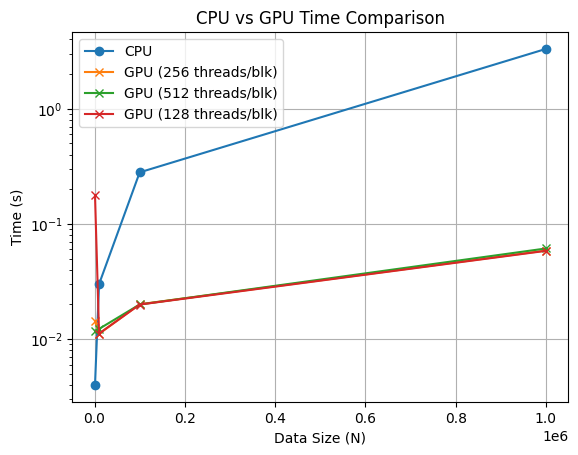

In [5]:
import matplotlib.pyplot as plt

N = [1000, 10000, 100000, 1000000] # dataset sizes
cpu_times = [0.004, 0.03, 0.28, 3.3]  # CPU times in seconds
gpu_times_128_threads = [0.176384, 0.011168, 0.019936, 0.058336]  # GPU times for 128 threads in seconds
gpu_times_256_threads = [0.014304, 0.011104, 0.020064, 0.058688]  # GPU times for 256 threads in seconds
gpu_times_512_threads = [0.011840, 0.012256 , 0.019968 , 0.061152] # GPU times for 512 threads in seconds
# Plotting CPU times
plt.semilogy(N, cpu_times, label='CPU', marker='o')

# Plotting GPU times
plt.semilogy(N, gpu_times_256_threads, label='GPU (256 threads/blk)', marker='x')

plt.semilogy(N, gpu_times_512_threads, label='GPU (512 threads/blk)', marker='x')

plt.semilogy(N, gpu_times_128_threads, label='GPU (128 threads/blk)', marker='x')


plt.xlabel('Data Size (N)')
plt.ylabel('Time (s)')
plt.title('CPU vs GPU Time Comparison')
plt.legend()
plt.grid(True)
plt.show()


We observe that for different configurations the GPU time taken are similar. Compared to the CPU time, we see that for small datasets the CPU takes lesser time than GPU. However, as datasets grow larger, we see that the GPU speed up grows exponentially as depicted in the graph.